<h1> Uniform Manifold Approximation and Projection </h1>  

<h3>https://ichi.pro/ko/cheoeumbuteo-umapeul-peulogeulaeminghaneun-bangbeob-253918307112446 / https://arxiv.org/pdf/1802.03426.pdf 를 많이 참조함 </h3>

In [159]:
import pandas as pd 
import numpy as np
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import trange

In [235]:
class UMAP(object):
    def __init__(self, n_neighbors:int, n_components:int, min_dist:float = .1, spread:float = 1., n_epoch = 300, random_state = None):
        self.n_neighbors = n_neighbors
        if min_dist > 1:
            raise ValueError('min dist must be same or lower than 1')
        else:
            self.min_dist = min_dist
        self.n_components = n_components
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.alpha = alpha
        self.beta = beta
        self.spread = spread
        
    def fit_transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        self.n_ = X.shape[0]
        rgen = np.random.RandomState(self.random_state)
        
        #step1. construct high-dimention prop P
        dist = sklearn.metrics.pairwise.euclidean_distances(X,X)
        rho = np.where(dist.argsort(0).argsort(0)==1, dist, 0).sum(axis = 0)
        dist = dist - np.where(np.eye(len(dist)) ,0,np.column_stack([rho for _ in range(len(dist))]))
        
        sigma = []
        def compute_sum_prop(sigma, row):
            return np.sum(np.exp(-(row/sigma)))       
        for row in dist:
            sigma_l = 0.
            sigma_h = 1000.
            for i in range(100):
                sigma = (sigma_l + sigma_h)/2.
                c_s = compute_sum_prop(sigma, row)
                if self.n_neighbors - c_s < 1e-5:
                    sigma.append(c_s)
                    break
                if c_s < self.n_neighbors:
                    sigma_l = sigma
                else:
                    sigma_h = sigma
        
        P = dist * np.column_stack([sigma for _ in range(len(dist))])
        P = (P + P.T) / 2
        
        #step2. construct low dimension and its prop Q
        try :
            reducer = sklearn.manifold.SpectralEmbedding(n_components = self.n_components, n_neighbors = self.n_neighbors, random_state = self.random_state)
            self.low_dimension_ = reducer.fit_transform(P)
        except:
            self.low_dimension_ = rgen.standard_t(loc = 0., scale = 1 , size = self.n_ * self.n_components).reshape(self.n, self.n_components)
        
        dist2 = sklearn.metrics.pairwise.euclidean_distances(self.low_dimension_)
        dist_low_dim_ = lambda dist, a, b: np.power(( 1 + a * np.power(dist, 2*b) ), -1)
        def get_a_b_(min_dist):
            x = np.linspace(0,3,300)
            y = np.where(x <= min_dist, 1, np.exp(-x + min_dist))
            p, _ = optimize.curve_fit(dist_low_dim_, x, y)
            return p
        self.a_, self.b_ = get_a_b_(self.min_dist)
        Q = dist_low_dim_(dist2, self.a_, self.b_)
        
        #step3. adjust low dimension location by gradient descent for n_iter times
        alpha = 1.
        
        for i in trange(1, self.n_epoch+1):
            low_dimension_grad_ = []
            self.low_dimension_ = self.low_dimension_ - (alpha * low_dimension_grad_)
            alpha = 1. - (i / self.n_epoch)
        
        return self.low_dimension_
        

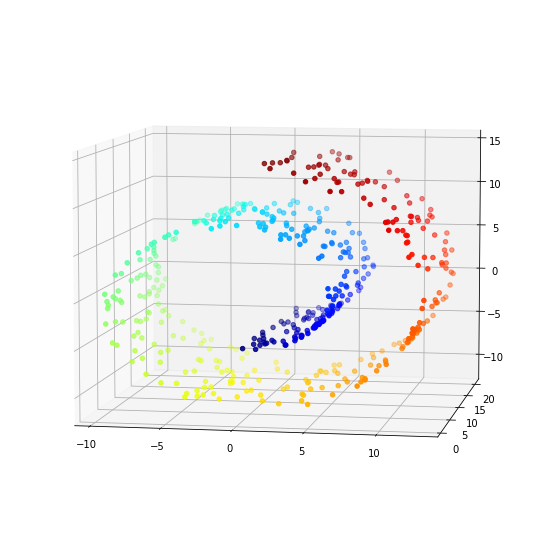

In [234]:
X, color = datasets.make_swiss_roll(random_state=42, n_samples = 500)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)

In [248]:
def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact=np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)